# Sentiment Analysis of Amazon Reviews: Naive Bayes
## By Timothy Pace
This program builds a multinomial Naive Bayes model for sentiment analysis of Amazon reviews. The original Kaggle dataset can be found at: https://www.kaggle.com/bittlingmayer/amazonreviews

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
import bz2
import re
import os
import gc

from nltk.corpus import stopwords
from nltk import PorterStemmer

from sklearn.metrics import auc, roc_curve

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import multiprocessing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Gets the Data

In [2]:
train = bz2.BZ2File('./data/amazonreviews/train.ft.txt.bz2')
test = bz2.BZ2File('./data/amazonreviews/test.ft.txt.bz2')


In [3]:
train = train.readlines()
test = test.readlines()


In [4]:
gc.collect()


7

### Pre-Processes the Data & Performs Exploratory Data Analysis

In [5]:
train = [x.decode('utf-8') for x in train]
test = [x.decode('utf-8') for x in test]


In [6]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train]
train_corpus = [x.split(' ', 1)[1][:-1] for x in train]

print(train_labels[:3])
print(train_corpus[:3])


[1, 1, 1]
['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.", 'Amazing!: This soundtrack is my favorite musi

In [7]:
del train
gc.collect()


0

In [8]:
train_dict = {'text': train_corpus, 'labels': train_labels}
train_df = pd.DataFrame(train_dict)

train_df.head()


,text,labels
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [9]:
train_df.describe()


,labels
count,3600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [10]:
del train_labels, train_corpus
gc.collect()


7

In [11]:
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test]
test_corpus = [x.split(' ', 1)[1][:-1] for x in test]

print(test_labels[:3])
print(test_corpus[:3])


[1, 1, 0]
['Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"', "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those k

In [12]:
del test
gc.collect()


0

In [13]:
test_dict = {'text': test_corpus, 'labels': test_labels}
test_df = pd.DataFrame(test_dict)

test_df.head()


,text,labels
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


In [14]:
test_df.describe()


,labels
count,400000.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [15]:
del test_corpus, test_labels
gc.collect()


7

In [16]:
test_df = test_df.sample(frac = .1)
test_df.describe()


,labels
count,40000.000000
mean,0.499950
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [17]:
train_df = train_df.sample(frac = .1)
train_df.describe()


,labels
count,360000.000000
mean,0.500406
std,0.500001
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [18]:
def normalize_text (row) : 
    RE_PREPROCESS = r'\W+|\d+'
    return re.sub(RE_PREPROCESS, ' ', row.text).lower()

train_df['clean_text'] = train_df.apply(normalize_text, axis=1)
test_df['clean_text'] = test_df.apply(normalize_text, axis=1)


In [19]:
sample_reviews = pd.concat([test_df, train_df])
sample_reviews.describe()


,labels
count,400000.00000
mean,0.50036
std,0.50000
min,0.00000
25%,0.00000
50%,1.00000
75%,1.00000
max,1.00000


#### Top 100 Term Frequencies from All Review Samples

In [20]:
all_sample_reviews = pd.Series(' '.join(sample_reviews['clean_text']).lower().split()).value_counts()
top_100_terms = all_sample_reviews[~all_sample_reviews.index.isin(stopwords.words('english'))][:100]
print(top_100_terms)

top_n_terms = top_100_terms[:2].index.values.tolist()


book          218995
one           153479
great         118713
good          115811
like          114396
would          94000
read           78580
get            76440
time           75111
movie          66858
really         63679
well           61538
much           56631
first          56170
even           56056
love           52358
buy            50141
product        49389
best           47184
cd             46497
better         45898
use            45264
work           43851
also           42731
bought         41310
could          41020
new            40021
story          39637
album          39455
way            39147
little         38675
money          37237
back           37210
many           37115
think          36535
music          35100
make           34845
never          34450
know           34384
two            34233
still          34066
got            33825
bad            33166
ever           32266
see            32189
made           32101
want           31757
people       

#### Top 100 Word Frequencies from Negative Review Samples

In [21]:
negative_reviews = sample_reviews[sample_reviews.labels == 0]
negative_reviews = pd.Series(' '.join(negative_reviews['clean_text']).lower().split()).value_counts()
negative_reviews[~negative_reviews.index.isin(stopwords.words('english'))][:100]


book            105437
one              78827
like             60259
would            58194
good             48832
get              43987
time             40427
movie            36262
even             35588
read             33186
buy              32094
much             31550
product          31260
money            30967
really           30927
first            28970
work             27108
better           26859
great            26738
bad              25850
could            25122
bought           24711
use              23552
well             23220
back             22360
way              20859
never            20513
got              19855
new              19728
two              19531
waste            19365
make             18789
cd               18718
also             18610
think            18519
made             18486
know             18250
many             17619
want             17512
quality          17484
story            17070
little           16682
people           16585
see        

#### Top 100 Term Frequencies from Positive Review Samples

In [22]:
positive_reviews = sample_reviews[sample_reviews.labels == 1]
positive_reviews = pd.Series(' '.join(positive_reviews['clean_text']).lower().split()).value_counts()
positive_reviews[~positive_reviews.index.isin(stopwords.words('english'))][:100]


book          113558
great          91975
one            74652
good           66979
like           54137
read           45394
love           39681
well           38318
best           35871
would          35806
time           34684
really         32752
get            32453
movie          30596
cd             27779
first          27200
album          25193
much           25081
also           24121
story          22567
little         21993
music          21822
use            21712
even           20468
new            20293
many           19496
still          19091
better         19039
recommend      18403
easy           18371
way            18288
product        18129
buy            18047
excellent      18037
think          18016
life           17613
years          17509
work           16743
ever           16634
bought         16599
old            16173
know           16134
make           16056
could          15898
see            15872
books          15839
find           15590
people       

In [23]:
del sample_reviews, negative_reviews, positive_reviews, all_sample_reviews, top_100_terms
gc.collect()


63

In [24]:
train_labels = train_df.labels.values
train_corpus = train_df.clean_text.values
test_labels = test_df.labels.values
test_corpus = test_df.clean_text.values


### Count Vectorizer, TFIDF Transformer, & Naive Bayes Pipeline: Model Training

In [25]:
stemmer = PorterStemmer()
tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
text_clf = Pipeline([('vect', CountVectorizer(tokenizer=tokenize,
                                              ngram_range=(0, 2),
                                              stop_words= stopwords.words('english') + top_n_terms)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

mdl = text_clf.fit(train_corpus, train_labels)
y_score_train = mdl.predict_proba(train_corpus)
y_score_test = mdl.predict_proba(test_corpus)


###  Naive Bayes Model Evaluation

In [26]:
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, y_score_train[:, 1])
train_roc_auc = auc(train_fpr, train_tpr)

print('Train AUC-PR: {0:1f}'.format(train_roc_auc))


Train AUC-PR: 0.988078


In [27]:
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, y_score_test[:, 1])
test_roc_auc = auc(test_fpr, test_tpr)

print('Test AUC-PR: {0:1f}'.format(test_roc_auc))


Test AUC-PR: 0.950662


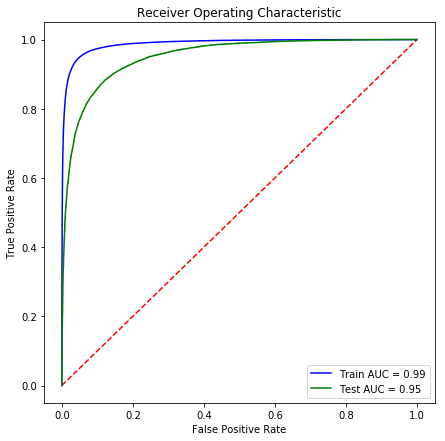

In [28]:
figure(figsize=(7, 7))
plt.title('Receiver Operating Characteristic')
plt.plot([0,1],[0,1],'r--')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label='Test AUC = %0.2f'% test_roc_auc)
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
